In [1]:
import itertools
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import warnings
from pylab import rcParams
from ljungbox import *
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [2]:
%matplotlib inline
rcParams['figure.figsize'] = 15, 10
warnings.filterwarnings('ignore')

In [3]:
file_path = 'airline.csv'

In [4]:
df_germany = pd.read_csv(file_path)

In [5]:
df_germany.head()

,Month,Data
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [6]:
df_germany.set_index(pd.to_datetime(df_germany.Month, format="%Y-%m"), drop=True, inplace=True)
df_germany.drop('Month', axis=1, inplace=True)

In [7]:
df_germany.head()

,Data
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [8]:
df_germany.shape

(144, 1)

In [9]:
count_nan = len(df_germany) - df_germany.count()
count_nan

Data    0
dtype: int64

In [10]:
df_germany = df_germany.sort_index()

In [11]:
df_germany.describe()

,Data
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [12]:
df_germany.tail(10)

,Data
Month,
1960-03-01,419
1960-04-01,461
1960-05-01,472
1960-06-01,535
1960-07-01,622
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390


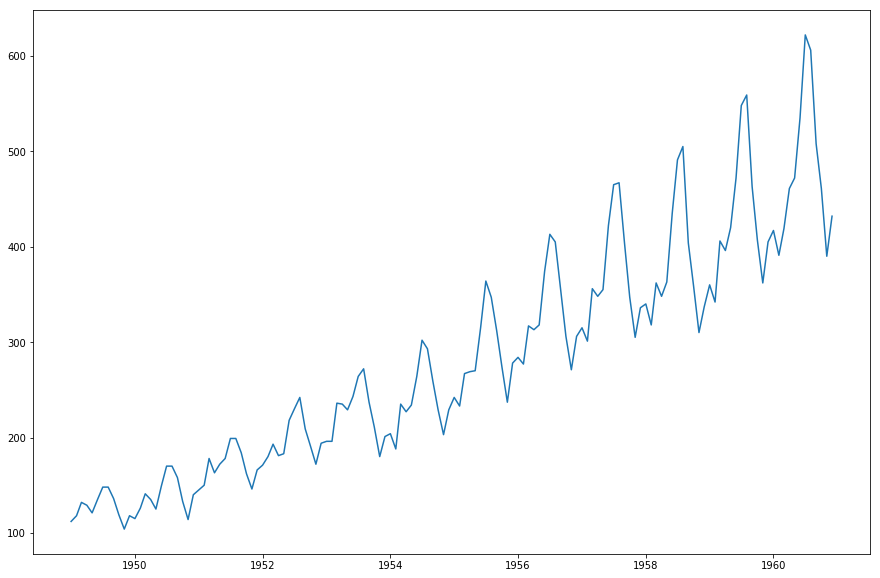

In [13]:
plt.plot(df_germany.Data)

In [14]:
def stationarity_check(ts):
    # Determing rolling statistics
    roll_mean = ts.rolling(12).mean()
    # Plot rolling statistics:
    plt.plot(ts, color='green',label='Original')
    plt.plot(roll_mean, color='blue', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show(block=False)
    # Perform Augmented Dickey-Fuller test:
    print('Augmented Dickey-Fuller test:')
    df_test = adfuller(ts)
    df_output = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print("df_output: \n",df_output)
    for key,value in df_test[4].items():
        df_output['Critical Value (%s)'%key] = value
    print(df_output)

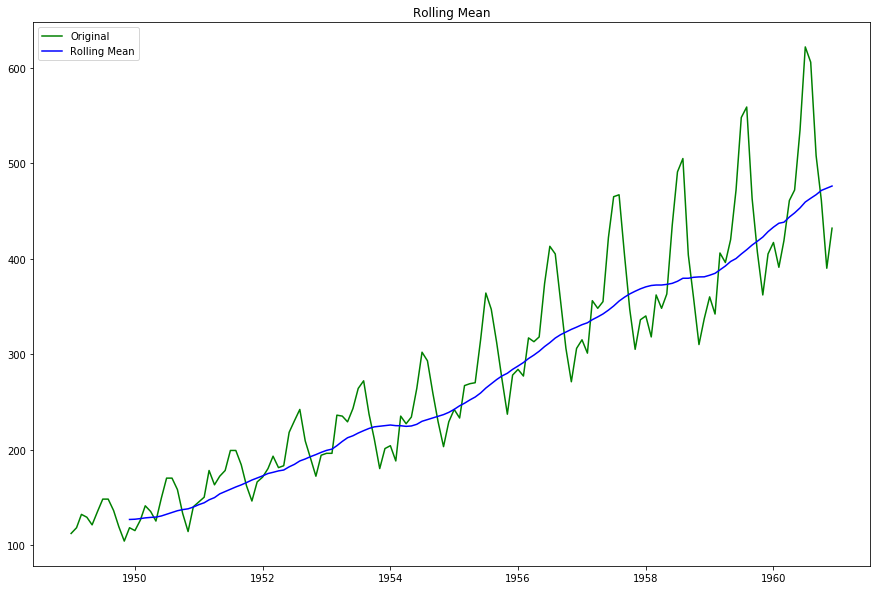

Augmented Dickey-Fuller test:
df_output: 
 Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
dtype: float64
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [15]:
stationarity_check(df_germany.Data)

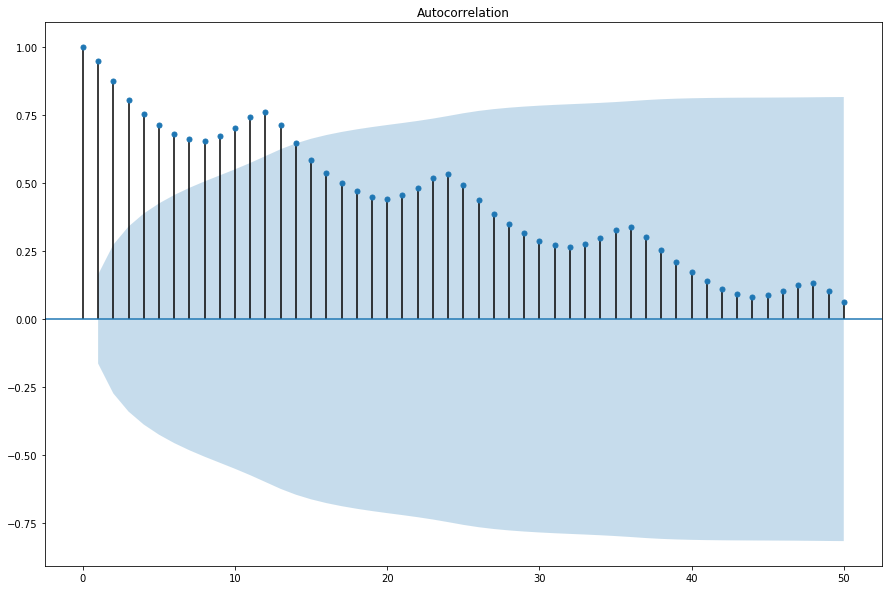

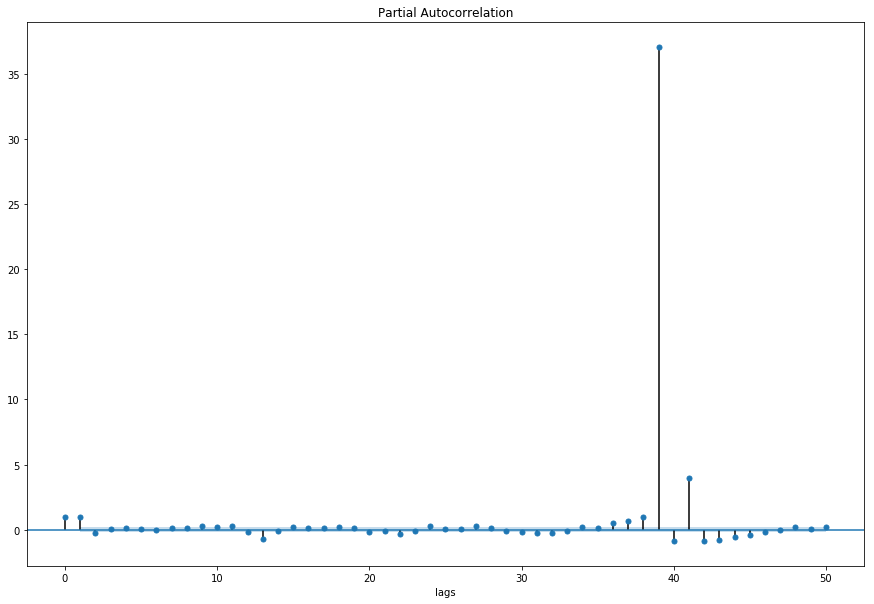

In [16]:
plot_acf(df_germany.Data, lags=50)
plot_pacf(df_germany.Data, lags=50)
plt.xlabel('lags')
plt.show()

In [17]:
ts_log = np.log(df_germany['Data'])

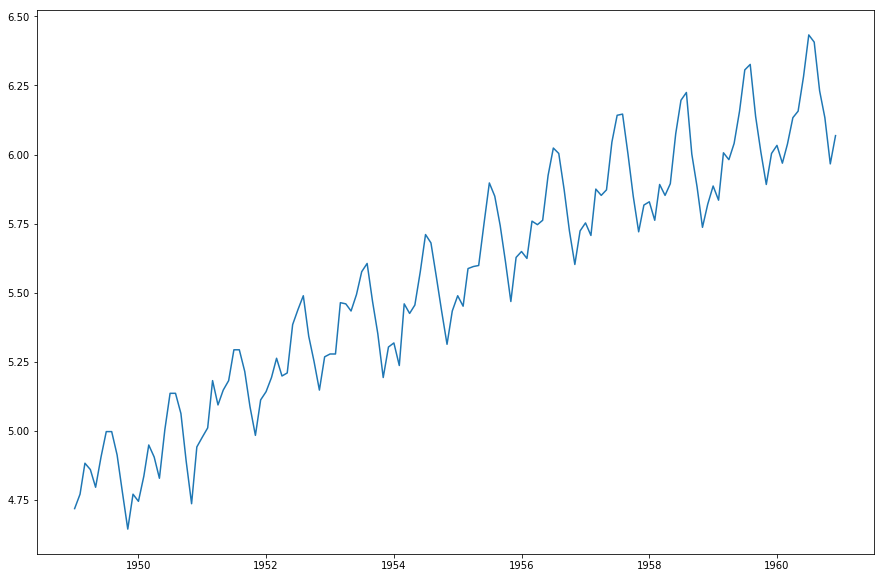

In [18]:
plt.plot(ts_log)

In [19]:
ts_log_diff = ts_log - ts_log.shift()

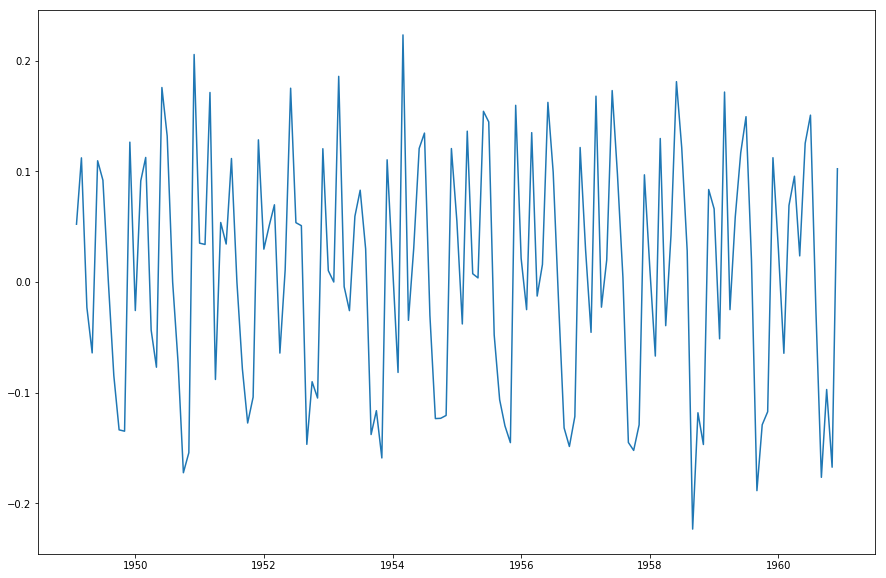

In [20]:
plt.plot(ts_log_diff)

In [21]:
ts_log_diff.dropna(inplace=True)

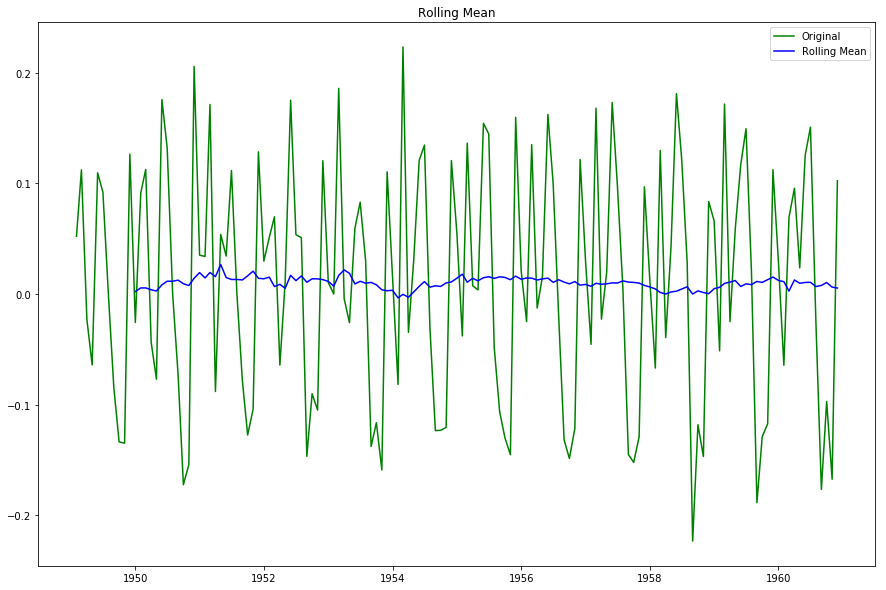

Augmented Dickey-Fuller test:
df_output: 
 Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
dtype: float64
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [22]:
stationarity_check(ts_log_diff)

In [23]:
p = q = range(1, 4)
print (p)

range(1, 4)


In [24]:
pq = itertools.product(p, q)
for param in pq:
    try:
        mod = ARMA(ts_log_diff,order=param)
        results = mod.fit()
        print('ARMA{} - AIC:{}'.format(param, results.aic))
    except:
        continue

ARMA(1, 1) - AIC:-241.60771402612266
ARMA(1, 2) - AIC:-265.18969059501154
ARMA(1, 3) - AIC:-263.2333163543199
ARMA(2, 1) - AIC:-270.15122169786815
ARMA(2, 2) - AIC:-287.280807921723
ARMA(2, 3) - AIC:-284.072115683415
ARMA(3, 1) - AIC:-270.08508122555014
ARMA(3, 2) - AIC:-270.1585990734438
ARMA(3, 3) - AIC:-289.4829058922482


In [25]:
p = q = range(0, 4)
r = range(0,2)
pqr = itertools.product(p, r, q)
for param in pqr:
    try:
        mod = ARIMA(ts_log_diff,order=param)
        results = mod.fit()
        print('ARIMA{} - AIC:{} - MSE:{}'.format(param, results.aic, np.sum(np.square(results.resid))))
    except:
        continue

ARIMA(0, 0, 0) - AIC:-231.56489500229378 - MSE:1.612298185849132
ARIMA(0, 0, 1) - AIC:-237.5073149855421 - MSE:1.524538158491223
ARIMA(0, 0, 2) - AIC:-240.37895402025066 - MSE:1.4721401352140102
ARIMA(0, 0, 3) - AIC:-257.8902855861256 - MSE:1.2783466734526467
ARIMA(0, 1, 0) - AIC:-162.71343086452043 - MSE:2.5700150262171153
ARIMA(0, 1, 1) - AIC:-222.11664129706332 - MSE:1.6583140423728162
ARIMA(0, 1, 2) - AIC:-228.4115648621787 - MSE:1.567029853144637
ARIMA(0, 1, 3) - AIC:-230.59179582330808 - MSE:1.5176312333970379
ARIMA(1, 0, 0) - AIC:-235.38589888263135 - MSE:1.5476170228387836
ARIMA(1, 0, 1) - AIC:-241.60771402612266 - MSE:1.4597312960068098
ARIMA(1, 0, 2) - AIC:-265.18969059501154 - MSE:1.2172999172674008
ARIMA(1, 0, 3) - AIC:-263.2333163543199 - MSE:1.2169821316531961
ARIMA(1, 1, 0) - AIC:-173.73789389552235 - MSE:2.343550115651358
ARIMA(2, 0, 0) - AIC:-237.60463569752864 - MSE:1.50230336855364
ARIMA(2, 0, 1) - AIC:-270.15122169786815 - MSE:1.1753125258994035
ARIMA(2, 0, 2) - AIC

In [34]:
mod = sm.tsa.statespace.SARIMAX(ts_log_diff,
                                order = (1, 1, 0),
                                seasonal_order= (0,0,0,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

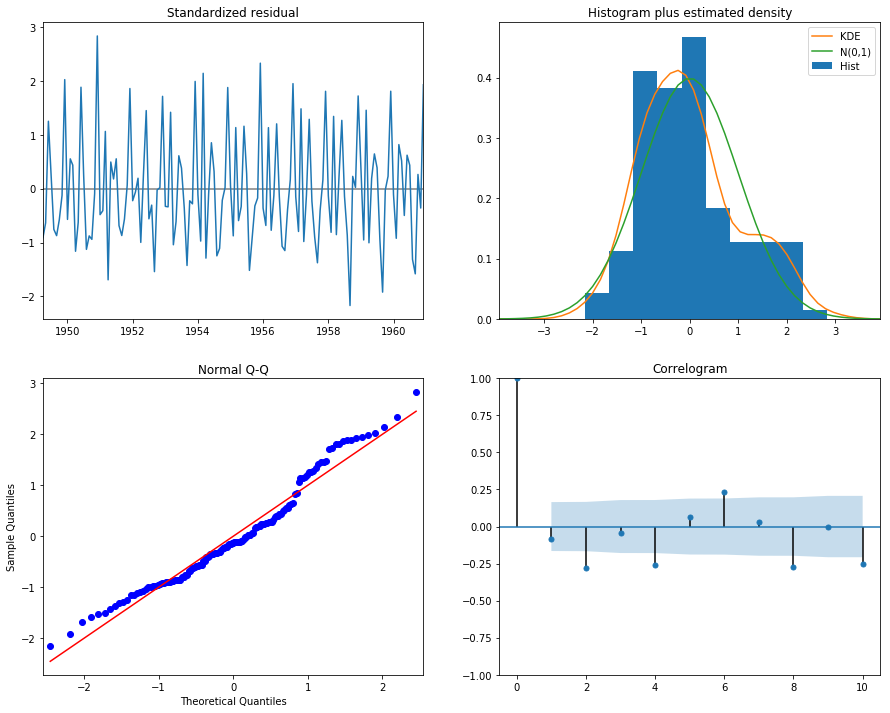

In [35]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [36]:
residuals = results.resid

In [37]:
h, pV, Q, cV = lbqtest(residuals, range(1, 20), alpha=0.1)
print ('lag   p-value          Q    c-value   rejectH0')
for i in range(len(h)):
    print ("%-2d %10.3f %10.3f %10.3f      %s" % (i+1, pV[i], Q[i], cV[i], str(h[i])))

lag   p-value          Q    c-value   rejectH0
1       0.000    138.138      2.706      True
2       0.000    276.437      4.605      True
3       0.000    413.905      6.251      True
4       0.000    546.512      7.779      True
5       0.000    673.574      9.236      True
6       0.000    801.056     10.645      True
7       0.000    927.591     12.017      True
8       0.000   1053.067     13.362      True
9       0.000   1178.293     14.684      True
10      0.000   1303.114     15.987      True
11      0.000   1419.261     17.275      True
12      0.000   1535.641     18.549      True
13      0.000   1646.123     19.812      True
14      0.000   1757.005     21.064      True
15      0.000   1866.190     22.307      True
16      0.000   1968.627     23.542      True
17      0.000   2063.923     24.769      True
18      0.000   2159.606     25.989      True
19      0.000   2253.057     27.204      True
